In [1]:
import sys
sys.path.append('..')
import quarantines as Q
import quarantines_mongo as qm
import graph_generators as gg 
import networkx as nx 
import networkit as nk
import pymongo
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from tabulate import tabulate
from scipy import stats
from pprint import pprint
import os 
import random
import experiment_helpers as eh
import utils
import bisect
from curlyBrace import curlyBrace
sns.set()

In [2]:
# For weaker quarantines, plot V graphs 
# Gather and plot VGraphs for BA10 + FB 
data = eh.gather_data()
BA_BASE = 'ba_10'
BA_KEYS = [_ for _ in data if _.startswith(BA_BASE)]


In [3]:
[_ for _ in data.keys() if _.endswith('_0.5')]

['ws_10_0.05_0.5',
 'ba_5_0.5',
 'plc_5_0.5_0.5',
 'ba_10_0.5',
 'rw_0.91_0.94_0.5',
 'plc_10_0.25_0.5',
 'nn_0.88_6_0.5',
 'gemsec_fb_ARTIST_R_0.5']

In [4]:
def get_single_v(name, second_wave=0.05, no_filter=False):
    """ A little complicated: 
        - Collects data and partitions by qprop 
        - Then splits into "alive" and "dead" groups, depending on presence of "second wave"
          by determining if final#R is > (1+second_wave) * qprop
        - For qprops with no living groups, reports the pop average
    Ultimately returns a list of 
        [(qprop, livingMean, livingStd)] for all qprops
    """
    N = len(eh.parse_data_name(name))
    series = sorted(eh.group_by_qprop(data[name]).items())
    output = [] 
    for qprop, prop_list in series:
        Rs = [_ / N for _ in prop_list['final_R']] 
        live_Rs = [_ for _ in Rs if _ > (1 + second_wave) * qprop]
        if len(live_Rs) == 0 or no_filter:
            live_Rs = Rs
        output.append((qprop, np.mean(live_Rs), np.std(live_Rs)))
    return output 
    
    
    
def plot_single_v(name, fig, ax, c, label=None, second_wave=0.05, no_filter=False):
    triplist = get_single_v(name, second_wave=second_wave, no_filter=no_filter)
    ax.plot(*utils.select_mean(triplist), color=c, label=label)
    ax.fill_between(*utils.plotfill_trips(triplist), color=c, alpha=0.2)
    return min(triplist, key=lambda t: t[1])[0]


def plot_i_v(name, fig, ax, c, label=None, ls='solid'):
    N = len(eh.parse_data_name(name))
    series = sorted(eh.group_by_qprop(data[name]).items())
    triplist = [] 
    for qprop, prop_list in series:
        Is = [_ / N for _ in prop_list['max_I']] 
        triplist.append((qprop, np.mean(Is), np.std(Is)))
    ax.plot(*utils.select_mean(triplist), color=c, label=label, ls=ls)
    ax.fill_between(*utils.plotfill_trips(triplist), color=c, alpha=0.2)    
    return min(triplist, key=lambda t: t[1])[0]

In [5]:
def r_mapper(name):
    rval = float(name.split('_')[-1])
    if int(rval) == float(rval):
        val = str(int(rval))
    else:
        val = '1/' + str(round(1 / float(rval)))
    return val
        
    


In [6]:
def get_v_plot_series(prefix):
    keys = [_ for _ in data if _.startswith(prefix)]
    fig, ax = plt.subplots(figsize=(8,8))
    for i, k in enumerate(sorted(keys, key=lambda s: float(s.split('_')[-1]), reverse=True)):
        plot_single_v(k, fig, ax, utils.c(-i), label=r_mapper(k))
    ax.legend(title=r'$\beta/\gamma$', loc='lower right', ncol=1)
    ax.set_xlabel('Quarantine Threshold')
    ax.set_ylabel('Total proportion infected')
    return fig, ax 


Text(0.5, 1.0, 'Varying Infection Strength')

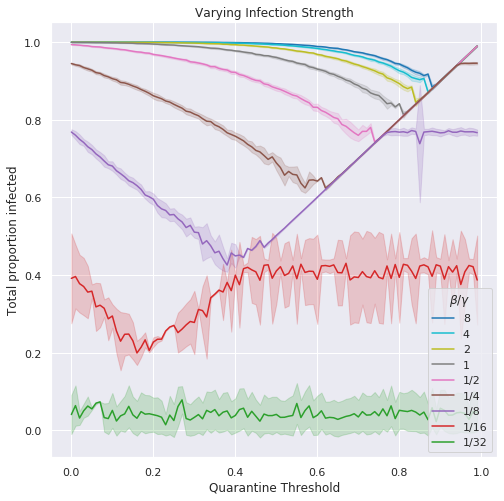

In [7]:
fig, ax =get_v_plot_series('ba_10')
ax.set_title("Varying Infection Strength")

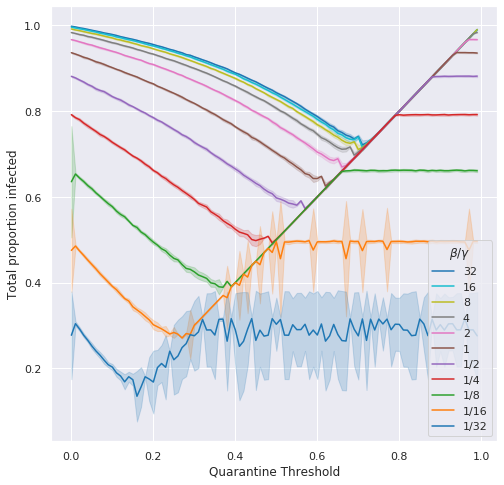

In [8]:
fig, ax = get_v_plot_series('gemsec_fb_ARTIST_R_')

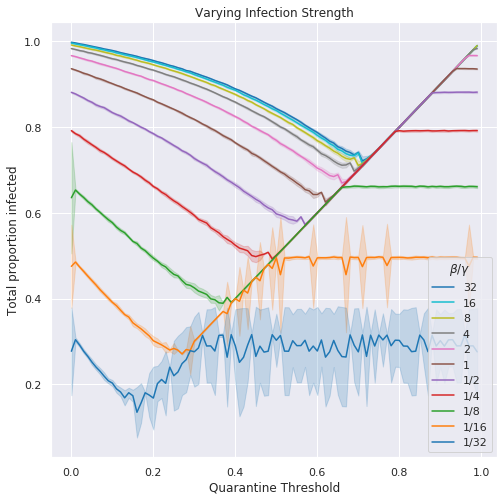

In [11]:
ax.set_title("Varying Infection Strength")
fig